В бутстрепе, если мы хотим сравнить две выборки, то нельзя смотреть  
где находится исходная разница средних в бутстрапированной выборке  
Так как мы берем бутстреп из наших выборок и впролне реально.что наша разность  
будет близка к с реднему бутстропированной выборки  
Поэтому p value нужно определять по месту нуля в бутстропированной выборке

In [1]:
import numpy as np

In [10]:
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
df = pd.read_csv('conversion.csv', header = 0, names=['temp', 'control', 'test']).iloc[:, 1:]
df.head()

,control,test
0,0,1
1,0,0
2,1,1
3,0,1
4,0,1


In [6]:
base_dif = np.mean(df.test - df.control)
base_dif

0.6325

In [7]:
np.mean(df.control)

0.0925

In [8]:
np.mean(df.test)

0.725

In [11]:
st.ttest_ind(df.test, df.control)

TtestResult(statistic=33.58893709209845, pvalue=1.368955091223808e-187, df=1598.0)

ConfidenceInterval(low=0.5949999999999999, high=0.6699999999999999)


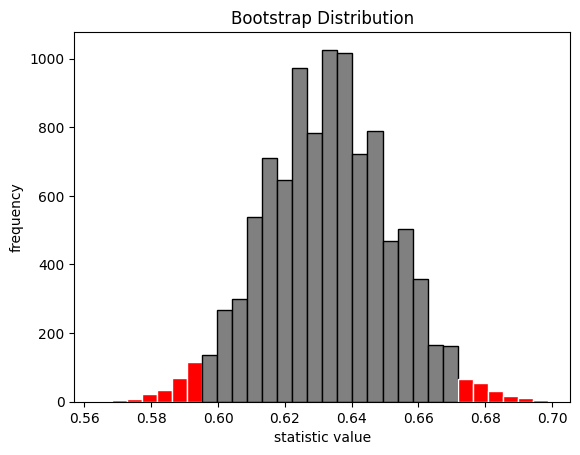

In [12]:
def my_statistic(sample1, sample2, axis=-1):
     return np.mean(sample1 - sample2, axis=-1)
data = (df.test.to_numpy(), df.control.to_numpy())
res = st.bootstrap(data, my_statistic, method='basic', random_state=1)
print(res.confidence_interval)
fig, ax = plt.subplots()
_, _, bars = ax.hist(res.bootstrap_distribution, bins=30, ec='w')
for bar in bars:
    if bar.get_x() < res.confidence_interval[0] or bar.get_x() > res.confidence_interval[1]:
        bar.set_facecolor('red')
    else:
        bar.set_facecolor('grey')
        bar.set_edgecolor('black')
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

In [14]:
boot_dist = res.bootstrap_distribution
st.norm(loc=np.mean(boot_dist), scale=np.std(boot_dist)).interval(0.95)

(0.5956604032772235, 0.6694298557486791)

Посмотрим p value для 0 (если различий нет, то разница должна быть 0)
Для этого посчитаем cdf для + и - среднего, чтобы получить 2 значения cdf
а теперь возьмем минимум и умножим на 2, так как альт гипотеза у нас.что
просто не равно 0, значит и справа и слева

In [17]:
p1 = st.norm(loc=np.mean(boot_dist), scale=np.std(boot_dist)).cdf(0)
p1

5.62118581486452e-248

In [16]:
p2 = st.norm(loc=-np.mean(boot_dist), scale=np.std(boot_dist)).cdf(0)
p2

1.0

In [18]:
p_value = min(p1, p2) * 2
f'p-value = {p_value}'

'p-value = 1.124237162972904e-247'

## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [ ]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа


In [ ]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    return {"boot_data": boot_data,
            "quants": quants,
            "p_value": p_value,
            'conf_int': norm(
                            loc = np.mean(boot_data),
                            scale = np.std(boot_data) ).interval(0.95) }

In [ ]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [ ]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

  0%|          | 0/1000 [00:00<?, ?it/s]

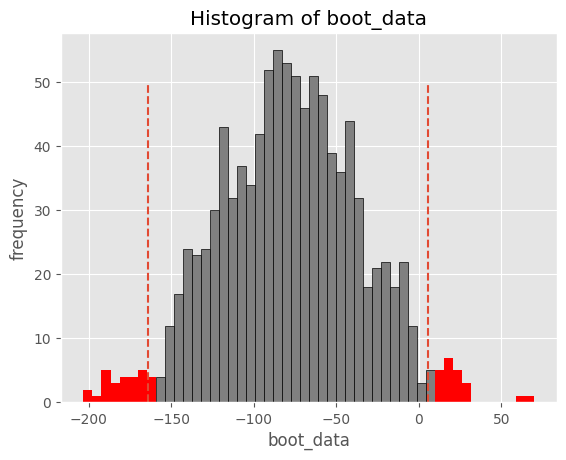

In [ ]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [ ]:
booted_data["p_value"] # альфа

0.07704553867678232

In [ ]:
booted_data["quants"] # ДИ

,0
0.025,-156.443158
0.975,13.080653


In [ ]:
booted_data['conf_int']

(-162.2098881166714, 7.264294525923788)

ConfidenceInterval(low=-160.9923921492898, high=7.565752002715357)


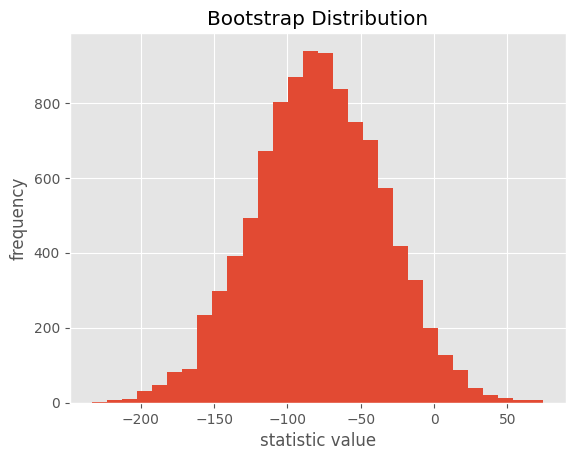

In [ ]:
def my_statistic(sample1, sample2, axis=-1):
     return np.mean(sample1 - sample2, axis=-1)
data = (df.sample_1, df.sample_2)
res = sts.bootstrap(data, my_statistic, method='basic', random_state=1)
print(res.confidence_interval)
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=30)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

In [ ]:
boot_data = res.bootstrap_distribution
p_1 = norm.cdf(
    x = 0,
    loc = np.mean(boot_data),
    scale = np.std(boot_data)
)
p_2 = norm.cdf(
    x = 0,
    loc = -np.mean(boot_data),
    scale = np.std(boot_data)
)
p_value = min(p_1, p_2) * 2
p_value

0.07131094160402714

In [ ]:
sample_1.mean() - sample_2.mean()

-77.75412385450977

In [ ]:
norm.cdf(
    x = sample_1.mean() - sample_2.mean(),
    loc = np.mean(boot_data),
    scale = np.std(boot_data)
)

0.5095808313613163

In [ ]:
data_ab = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [ ]:
data_ab.head()

,Unnamed: 0,value,experimentVariant
0,1,9.773113,Treatment
1,2,9.311246,Treatment
2,3,11.172828,Treatment
3,4,11.624510,Treatment
4,5,10.462331,Treatment


In [ ]:
data_ab.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [ ]:
data_ab.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,50


In [ ]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.367236


In [ ]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.420193


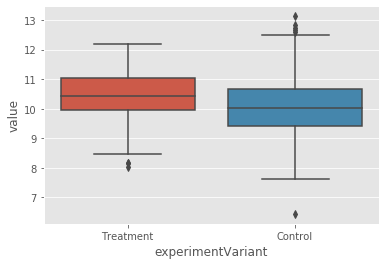

In [ ]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab)

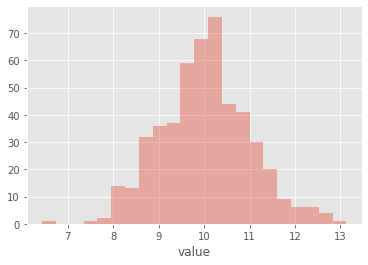

In [ ]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

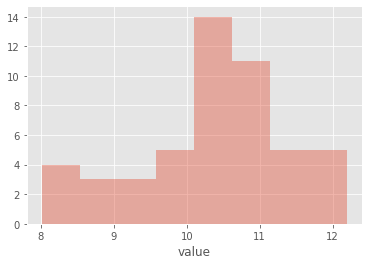

In [ ]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

In [ ]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value,
             data_ab[data_ab.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=9508.0, pvalue=0.0026182097937983984)

In [ ]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value,
             data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.3318589655730135, pvalue=0.02006953912735476)

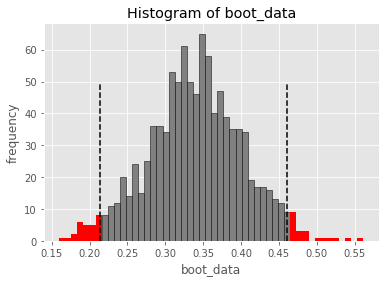

{'boot_data': [0.311642866467441,
  0.2803790000218313,
  0.4005482734655974,
  0.32241699979780175,
  0.2872937630089229,
  0.27287961160100044,
  0.40711603499799787,
  0.3690936793626043,
  0.31442313100356584,
  0.3264405369339072,
  0.3141494746140392,
  0.36217639930657425,
  0.3600679322461544,
  0.3822409502690522,
  0.25767715645642564,
  0.3502257291122056,
  0.45017909322063904,
  0.39331529641959173,
  0.37641133994118037,
  0.2733730365452141,
  0.35874696231011843,
  0.3192273055136867,
  0.27675144419167325,
  0.42658622136769625,
  0.2647589780577754,
  0.2503992450883882,
  0.5224798432298668,
  0.37170040799527326,
  0.4330724098946566,
  0.4275465872773983,
  0.3981626593726647,
  0.3063614609822789,
  0.33386657174716333,
  0.37546809912233653,
  0.44147520831410964,
  0.333238778578982,
  0.3241781100960534,
  0.3508647134722135,
  0.30965032230267353,
  0.39212007837745533,
  0.15967894149777367,
  0.3736640471691849,
  0.39730586129572465,
  0.561716758809035,
  

In [ ]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

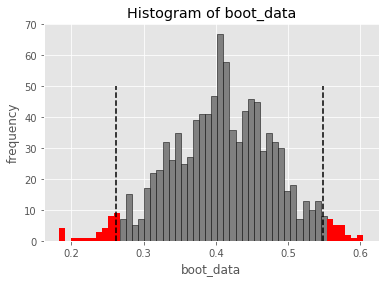

{'boot_data': [0.5147433326155504,
  0.3502958468606998,
  0.3481041014293007,
  0.3938835954395996,
  0.31773526043784983,
  0.5510466434841392,
  0.44702506285133037,
  0.4796694812157405,
  0.41662928095617957,
  0.5562520566066045,
  0.4563931507420982,
  0.2635290065303,
  0.45096901539327483,
  0.4403784659959049,
  0.47267379251589414,
  0.42715267588654005,
  0.3793186110718141,
  0.31207618843579965,
  0.4440736362395006,
  0.4937397514668307,
  0.41295553453867395,
  0.43867787050992035,
  0.44932367058575373,
  0.4083480114588003,
  0.3157690004779097,
  0.4233115252529842,
  0.4017388586352748,
  0.48701679063444914,
  0.465807153615831,
  0.41082097797400063,
  0.4186276357181846,
  0.45668777431082486,
  0.4080086980835773,
  0.4856184631233651,
  0.4205411114210005,
  0.37640103545195025,
  0.2400597077817146,
  0.485746095525065,
  0.41757160170829977,
  0.3933017157943697,
  0.47187506813098956,
  0.2488346699776498,
  0.47414759794946626,
  0.520738238910825,
  0.4479

In [ ]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [ ]:
5.4687657931866705e-08 < 0.0000002

True

In [ ]:
ads_data = pd.read_csv('ads_data.csv.zip')

In [ ]:
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time') \
    .reset_index()

event,ad_id,click,view
0,3,9.0,490.0
1,2132,1.0,95.0
2,2276,2.0,1454.0
3,2475,NaN,132.0
4,2643,3.0,286.0
...,...,...,...
350,121941,1.0,640.0
351,121943,15.0,1722.0
352,122042,1.0,155.0
353,122063,1.0,260.0
